# [CS 2770] Assignment 1

# **Image Classification and Convolutional Neural Networks (CNNs)**

In this class we will be relying on Python as a programming language and PyTorch as a primary framework of choice. For an introduction to Python for image manipulation you can do a refresher by first completing this notebook: [[Python, Numpy and Image Processing](https://colab.research.google.com/drive/1fI8_ga1ZG1vGPpJUwBMdxnPX6ntrUgrh)]. For a gentle introduction to PyTorch you can complete first this notebook: [[Python, PyTorch and Plotting](https://colab.research.google.com/drive/1UQM4Lzs1sKbmZ7g3D1f98ATTSZM5EyGW?usp=sharing)].


In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## **1. Preliminaries**

In this section, we will review some basic PyTorch to demonstrate its capabilities for gradient-based optimization. Consider for instance the following function:

$$ y = 4x + 3z^2$$

Your task is to find the gradient $\nabla y = \left(\frac{\partial y}{\partial x}, \frac{\partial y}{\partial z}\right)$ for when $x = 2$ and $z = 3$. How do we do this? There are three ways we can do this.


### **1.1 Analytical Derivation**

First, we can compute the analytical formula for this function as follows:

$$\frac{\partial y}{\partial x} = 4 \quad\text{ and }\quad \frac{\partial y}{\partial z} = 6z$$

We can easily see that the gradient at $(x,z) = (2, 3)$ is $\nabla y = (4, 18) $. No need to write any code.


### **1.2 Numerical Approximation**

The other method we can apply is based on a numerical approximation using the definition of derivatives. Let's have $y = f(x,z)$, then the definitions of partial derivatives can be expressed as follows:

$$ \frac{\partial}{\partial x} f(x,z) = \lim{h_x \to 0} \frac{f(x + h_x, z) - f(x, z)}{h_x}$$

$$ \frac{\partial}{\partial z} f(x,z) = \lim{h_z \to 0} \frac{f(x, z + h_z) - f(x, z)}{h_z}$$

We can quickly compute this below using some basic Python functions.


In [2]:
from collections.abc import Callable

type Func = Callable[[float, float], float]


def f(x: float, z: float) -> float:
    return 4 * x + 3 * z * z


def grad_x(f: Func, x: float, z: float, h: float = 0.0001) -> float:
    return (f(x + h, z) - f(x, z)) / h


def grad_z(f: Func, x: float, z: float, h: float = 0.0001) -> float:
    return (f(x, z + h) - f(x, z)) / h


print('grad_x:', grad_x(f, 2, 3), 'grad_z:', grad_z(f, 2, 3))

grad_x: 3.9999999999906777 grad_z: 18.000300000053926


As we can see, the approximation is fairly correct, returning almost the same result as the analytical derivation.


### **1.3 PyTorch Autograd**

Writing your own derivations is fine but PyTorch already implements the gradient based computation for all basic operations you might need and it keeps track of the operations that are being applied when using the PyTorch tensor datatype. Anytime you need to compute gradients you can call the `backward()` function on a tensor and it will apply the chain rule of calculus to compute the derivatives for all the history of operations applied to said tensor.


In [ ]:
import torch
from torch import Tensor


# This function assumes, x, z are PyTorch tensors.
# We could also restrict the data types in python3.
def f(x: Tensor, z: Tensor) -> Tensor:
    return 4 * x + 3 * z**2


x = torch.tensor(2.0, requires_grad=True)
z = torch.tensor(3.0, requires_grad=True)

# Compute the value of y.
y = f(x, z)

# Compute the gradients for all variables.
y.backward()

# Print the gradients
print('grad_x:', x.grad, 'grad_z:', z.grad)

grad_x: tensor(4.) grad_z: tensor(18.)


We can see that we can obtain the same result, except the PyTorch function is much more general. For starters, $x$ and $z$ could be vectors in this implementation without changing anything. There is no need to compute the analytical derivation and there is no need to have a separate function for each partial derivative. Another thing to keep in mind, usually we will be optimizing variables that we name $W = [w_1, w_2, ...]$ and we will use $y$ and $x$ to denote constants since those we use to represent the training data, so let us not get confused by this. You will be able to see this more clearly in the second part of the assignment section.


## **2. The SUN Dataset** [20pts]

In 2009, a group of researchers developed SUN397, a database of images that was supposed to cover as many categories of images of "scenes" as possible (see more information [here](https://vision.princeton.edu/projects/2010/SUN/)). The dataset has at least 100 images for each of 397 categories. The entire dataset fits in a 39GB tar file.


In [ ]:
import json
import pathlib
import sys
import time
from typing import Any, Literal

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import torchmetrics.classification as metrics
import torchvision.models as models
import torchvision.transforms.v2 as v2
import torchvision.transforms.v2.functional as v2F
from rich.console import Console
from rich.progress import BarColumn, Progress, TextColumn, TimeRemainingColumn
from torchmetrics import Metric

%config InlineBackend.figure_format = 'retina'

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False

# Auto determine the device to use (GPU or CPU).
device = torch.accelerator.current_accelerator(check_available=True)

In [6]:
def make_grid_np(images: list[np.ndarray], nrow: int) -> np.ndarray:
    rows = []
    for i in range(0, len(images), nrow):
        row = np.concat(images[i : i + nrow], axis=1)
        rows.append(row)
    return np.concat(rows, axis=0)

In [7]:
class SoftTargetCrossEntropy(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor, target: Tensor) -> Tensor:
        loss = torch.sum(-target * F.log_softmax(x, dim=-1), dim=-1)
        return loss.mean()

### **2.1 Creating a Custom Data Loader**

In PyTorch a dataset class must inherit from `torch.utils.data.Dataset` and it must override two methods: `__getitem__` and `__len__`. These methods must return a sample and the number of samples respectively.


In [8]:
from torchvision.datasets import VisionDataset
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_and_extract_archive


class SUN20(VisionDataset):
    """`The SUN20 Data Set <https://vision.princeton.edu/projects/2010/SUN/>`_.

    The SUN20 or Scene UNderstanding (SUN) is a dataset for scene recognition consisting of
    20 categories with 1000 images.
    """

    _DATASET_URL = 'https://sites.pitt.edu/~nem177/courses/fall24_cs1674/files/A7/'
    _DATASET_TRAIN_MD5 = 'a08debd651fca4fe830c57f295d7e7bc'
    _DATASET_VAL_MD5 = '52981dba0bb0d0309094acc18ca8c4d8'

    def __init__(
        self,
        root: str | pathlib.Path,
        split: Literal['train', 'val'] = 'train',
        transform: Callable | None = None,
        target_transform: Callable | None = None,
        download: bool = False,
        loader: Callable[[str | pathlib.Path], Any] = default_loader,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self._data_dir = pathlib.Path(self.root) / 'SUN20' / split
        self.split = split

        if download:
            self._download()

        if not self._check_exists():
            raise RuntimeError(
                'Dataset not found. You can use download=True to download it.'
            )

        with open(self._data_dir / 'ClassName.txt') as fp:
            self.classes = [c[3:].strip() for c in fp]

        self.class_to_idx = dict(zip(self.classes, range(len(self.classes))))
        self._image_files = sorted(self._data_dir.rglob('sun_*.jpg'))

        self._labels = [
            self.class_to_idx['/'.join(path.relative_to(self._data_dir).parts[1:-1])]
            for path in self._image_files
        ]
        self.loader = loader

    def __len__(self) -> int:
        return len(self._image_files)

    def __getitem__(self, idx: int) -> tuple[Any, Any]:
        image_file, label = self._image_files[idx], self._labels[idx]
        image = self.loader(image_file)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

    def get_original_image(self, idx: int) -> Image.Image:
        image_file = self._image_files[idx]
        image = self.loader(image_file)
        return image

    def _check_exists(self) -> bool:
        return self._data_dir.is_dir()

    def _download(self) -> None:
        if self._check_exists():
            return

        if self.split == 'train':
            download_and_extract_archive(
                self._DATASET_URL + 'SUN20-train-sm.tar.gz',
                download_root=self.root,
                md5=self._DATASET_TRAIN_MD5,
            )
        else:
            download_and_extract_archive(
                self._DATASET_URL + 'SUN20-val.tar.gz',
                download_root=self.root,
                md5=self._DATASET_VAL_MD5,
            )

### **2.2 Downloading the Data**

For this assignment, we created a subset of this dataset containing only 20 categories, and we pre-resized the images so that their longest size is 256 pixels. We also restricted each category to have exactly 50 images.


In [9]:
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
train_ds = SUN20(
    'deep-learning/datasets',
    split='train',
    transform=transform,
    download=True,
)
val_ds = SUN20(
    'deep-learning/datasets',
    split='val',
    transform=transform,
    download=True,
)
num_classes = len(train_ds.classes)
print(f'Number of classes: {num_classes}')

100%|██████████| 39.7M/39.7M [00:19<00:00, 2.04MB/s]
100%|██████████| 37.9M/37.9M [00:18<00:00, 2.02MB/s]


Number of classes: 20


### **2.3 Using the Custom Data Loader**

Here we show how to use the SUN20 dataset using our dataloader class, and we show how to explore images on this dataset. Before starting any project in vision + language it is always useful to write code to explore the dataset and visualize the data.


This dataset has 1000 training images.
Image 0 is an arch.
Image size is 379x250.


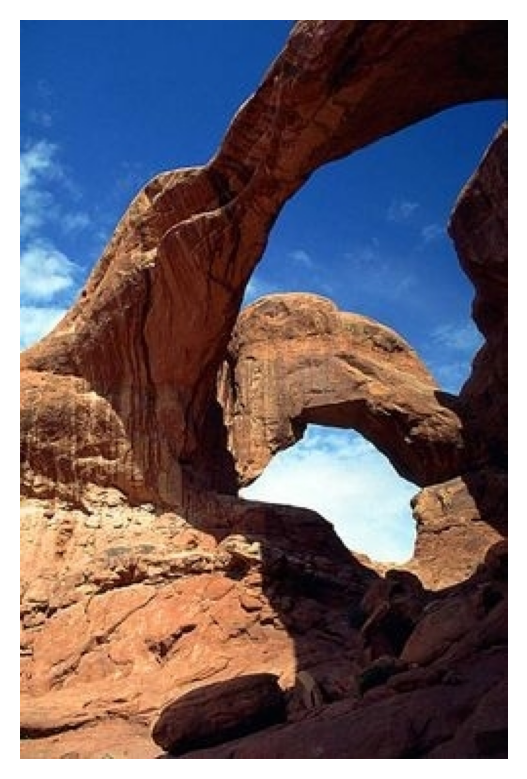

In [10]:
# 1. Datasets need to implement the __len__ method for this to work.
print(f'This dataset has {len(train_ds)} training images.')

# 2. Datasets need to implement the  __getitem__ method for this to work.
image_idx = 0  # Feel free to change this.
image, label = train_ds[image_idx]
image = v2F.to_pil_image(image)

print(f'Image {image_idx} is an {train_ds.classes[label]}.')
print(f'Image size is {image.height}x{image.width}.')

# Show the image.
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)
ax.imshow(image)
ax.axis('off')
plt.show()

### **2.4 Exploring Images in the SUN20 Dataset** [20pts]

**_Dataset Statistics:_** The objective of this section is for you to demonstrate that you know how to use the dataloader and know how to do some basic image manipulation using Python/PyTorch. Write code below to print the number of images shot in portrait mode (height larger than width) in the dataset for each category and sorted in decreasing order by this number. I'm including the numbers that I got. To get the full point your code should have the same output shown below and take less than 3.5 seconds on average to execute. **[10pts]**


In [11]:
from collections import defaultdict

stat = defaultdict(lambda: {'train': 0, 'val': 0})

for image, label in train_ds:
    class_name = train_ds.classes[label]
    if image.size(1) > image.size(2):
        stat[class_name]['train'] += 1
for image, label in val_ds:
    class_name = train_ds.classes[label]
    if image.size(1) > image.size(2):
        stat[class_name]['val'] += 1

stat = sorted(stat.items(), key=lambda x: x[1]['train'] + x[1]['val'], reverse=True)

for cls, counts in stat:
    train_cnt = counts['train']
    val_cnt = counts['val']

    print(
        f'{train_cnt} training images in portrait mode and '
        f'{val_cnt} validation images in portrait mode for '
        f'{cls}: total {train_cnt + val_cnt}'
    )

42 training images in portrait mode and 46 validation images in portrait mode for shower: total 88
40 training images in portrait mode and 35 validation images in portrait mode for tower: total 75
23 training images in portrait mode and 20 validation images in portrait mode for skyscraper: total 43
25 training images in portrait mode and 17 validation images in portrait mode for sauna: total 42
20 training images in portrait mode and 21 validation images in portrait mode for arch: total 41
18 training images in portrait mode and 23 validation images in portrait mode for bathroom: total 41
20 training images in portrait mode and 20 validation images in portrait mode for lighthouse: total 40
19 training images in portrait mode and 19 validation images in portrait mode for tree_house: total 38
9 training images in portrait mode and 10 validation images in portrait mode for dentists_office: total 19
6 training images in portrait mode and 7 validation images in portrait mode for hot_spring:

**Note:** This is just a warm up exercise. However an important thing to do before starting any new project. Exploring the dataset. Clearly this dataset is not ideal as some categories have a lot more images for training than others. However the validation set has an equal number of images. This is something we must take into account.


**_Visualizing:_** The objective of this section is for you to visualize some of the images in the training dataset and get a sense of how challenging is the required task. Please show a handful of images arranged in a 4x12 grid for a given category so they can be shown as a single image as in the example below for `skyscraper`. Include in your assignment the output for the category `marsh`. Note: You probably need to crop and resize the images in order to stitch them together. **[10pts]**


In [12]:
from torchvision.utils import make_grid

image_list = []

for image, label in train_ds:
    if label == train_ds.class_to_idx['marsh']:
        image = v2F.resize(image, size=[256, 256])
        image_list.append(image)

    if len(image_list) == 48:
        break

grid_image = make_grid(image_list, nrow=12)
grid_image = v2F.to_pil_image(grid_image)

fig = plt.figure(2, figsize=(18, 6))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid_image)
ax.axis('off')
ax.set_title('Sample images for class "marsh"')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Note:** Hopefully after visualzing the category `butte` you can visualize what this word really means.


## **3. Linear Classifiers**

In this section we will explore how to define and train linear classifiers for classifying images into one of the 20 categories of the SUN20 dataset we just defined in the earlier section.


### **3.1 Defining a Linear Classifier**

Now we can build a binary linear classifier and train it using SGD. We will rely on the PyTorch library for this purpose but we could use any. We don't need to compute gradients analytically since PyTorch keeps track of operations. In PyTorch model classes have to inherit from `torch.nn.Module` and the function that takes inputs and produces predicted values, has to be implemented in their `forward` function.


In [ ]:
# Let's define a linear classifier (One layer neural network).
# PyTorch supports batches so this model already can receive a set of inputs
# and not just one vector at a time. e.g. inputs of size batch_size x input_size.
model = nn.Sequential(
    nn.LazyLinear(num_classes),
    nn.Softmax(dim=1),
)

# Create a dummy row vector filled with random values.
dummy_vector = torch.rand(1, 32 * 32 * 3)

# Compute some predictions using the model.
predictions = model(dummy_vector)

# Show predictions from this randomly initialized model.
for i in range(0, num_classes):
    score = predictions[0, i].item()
    category = train_ds.classes[i]
    print(f'Prob("{category}") = {score:.2f}')

Prob("arch") = 0.05
Prob("bathroom") = 0.06
Prob("butte") = 0.02
Prob("dentists_office") = 0.03
Prob("hot_spring") = 0.03
Prob("jacuzzi/indoor") = 0.03
Prob("lighthouse") = 0.07
Prob("laundromat") = 0.08
Prob("lecture_room") = 0.04
Prob("living_room") = 0.05
Prob("library/indoor") = 0.04
Prob("mansion") = 0.07
Prob("marsh") = 0.07
Prob("mountain") = 0.03
Prob("sauna") = 0.04
Prob("shower") = 0.09
Prob("skyscraper") = 0.05
Prob("tower") = 0.04
Prob("tree_house") = 0.06
Prob("volcano") = 0.04


### **3.2 Stochastic Gradient Descent (SGD) Loop**

Now we proceed to train the classifier we defined in the earlier section using (mini-batch) Stochastic Gradient Descent (SGD). Please review the code in the following section especially carefully. Every line of code is important. If you don't understand what something does please feel free to contact the TA or me.


In [14]:
from dataclasses import dataclass, field, asdict


@dataclass
class SUN20Log:
    loss: list[float] = field(default_factory=list)
    acc: list[float] = field(default_factory=list)
    val_loss: list[float] = field(default_factory=list)
    val_acc: list[float] = field(default_factory=list)

In [15]:
def train(
    model: nn.Module,
    train_dl: utils.DataLoader[Tensor],
    val_dl: utils.DataLoader[Tensor],
    loss_fn: nn.Module,
    optimizer: optim.Optimizer,
    train_metric: Metric,
    val_metric: Metric,
    mixup_fn: v2.MixUp | None = None,
    scheduler: optim.lr_scheduler.LRScheduler | None = None,
    num_epochs: int = 10,
    model_name: str = 'model',
    log_name: str = 'log',
    device: torch.device | None = None,
    debug: bool = False,
):
    console = Console()
    progress = Progress(
        TextColumn('[bold blue]Epoch {task.fields[epoch]}/{task.fields[num_epochs]}'),
        BarColumn(bar_width=40),
        TextColumn('[progress.percentage]{task.percentage:>3.0f}%'),
        TextColumn('• loss: {task.fields[loss]:.4f}'),
        TextColumn('• acc: {task.fields[acc]:.4f}'),
        TextColumn('• time:'),
        TimeRemainingColumn(),
        console=console,
        transient=True,
    )

    if device is None:
        device = torch.accelerator.current_accelerator(check_available=True)

    log = SUN20Log()
    t1 = time.time()
    best_val_loss = np.inf

    if debug:
        progress.start()

    for epoch in range(1, num_epochs + 1):
        train_task = progress.add_task(
            'train',
            total=len(train_dl),
            epoch=epoch,
            num_epochs=num_epochs,
            loss=0.0,
            acc=0.0,
        )

        # Training phase
        model.train()
        train_loss = 0
        train_metric.reset()

        for X, y in train_dl:
            # Move data to the appropriate device
            X, y = X.to(device), y.to(device)

            if mixup_fn is not None:
                X, y = mixup_fn(X, y)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()

            # Accumulate loss and accuracy
            train_loss += loss.item()

            if mixup_fn is not None:
                y = torch.argmax(y, dim=1)
            acc = train_metric(pred, y)

            # Backpropagation
            optimizer.step()
            optimizer.zero_grad()

            progress.update(
                train_task,
                advance=1,
                loss=loss.item(),
                acc=acc.item(),
                refresh=True,
            )

        # Compute average training loss and accuracy
        avg_train_loss = train_loss / len(train_dl)
        avg_train_acc = train_metric.compute().item()

        val_task = progress.add_task(
            'validate',
            total=len(val_dl),
            epoch=epoch,
            num_epochs=num_epochs,
            loss=0.0,
            acc=0.0,
        )

        # Validation phase
        model.eval()
        val_loss = 0
        val_metric.reset()

        with torch.no_grad():
            for X, y in val_dl:
                # Move data to the appropriate device
                X, y = X.to(device), y.to(device)

                # Compute prediction error
                pred = model(X)
                loss = F.cross_entropy(pred, y)

                # Accumulate loss and accuracy
                val_loss += loss.item()
                acc = val_metric(pred, y)

                progress.update(
                    val_task,
                    advance=1,
                    loss=loss.item(),
                    acc=acc.item(),
                    refresh=True,
                )

        # Compute average validation loss and accuracy
        avg_val_loss = val_loss / len(val_dl)
        avg_val_acc = val_metric.compute().item()

        progress.remove_task(train_task)
        progress.remove_task(val_task)

        if scheduler is not None:
            scheduler.step()

        if debug:
            console.print(
                f'[bold green]Epoch {epoch}/{num_epochs}[/] '
                f'- loss: {avg_train_loss:.4f} '
                f'- acc: {avg_train_acc:.4f} '
                f'- val_loss: {avg_val_loss:.4f} '
                f'- val_acc: {avg_val_acc:.4f}'
            )
        else:
            print(
                f'Epoch {epoch}/{num_epochs} '
                f'- loss: {avg_train_loss:.4f} '
                f'- acc: {avg_train_acc:.4f} '
                f'- val_loss: {avg_val_loss:.4f} '
                f'- val_acc: {avg_val_acc:.4f}'
            )

        log.loss.append(avg_train_loss)
        log.acc.append(avg_train_acc)
        log.val_loss.append(avg_val_loss)
        log.val_acc.append(avg_val_acc)

        if avg_val_loss < best_val_loss:
            torch.save(model.state_dict(), f'{model_name}.ckpt')
            best_val_loss = avg_val_loss

            t2 = time.time()

            if debug:
              console.print(f'Model improved. Time taken until now: {t2 - t1:.2f} seconds.')
            else:
              print(f'Model improved. Time taken until now: {t2 - t1:.2f} seconds.')

    with open(f'{log_name}.json', 'w') as fp:
        json.dump(asdict(log), fp, indent=2)

    t2 = time.time()

    if debug:
        console.print('[bold green]Training finished![/]')
        console.print(f'Time taken: {t2 - t1:.2f} seconds.')
        progress.stop()
    else:
        print('Training finished!')
        print(f'Time taken: {t2 - t1:.2f} seconds.')

    return log

### **3.3 Training of Our Linear Classifier**

Running the code for training our LinearClassifier models and using data loaders for batch loading and assembly. Also carefully observe the usage of `torchvision.transforms`.


In [16]:
# Reset seed.
np.random.seed(42)
torch.manual_seed(42)

# Prepare the dataset.
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((32, 32)),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

train_ds = SUN20(
    'deep-learning/datasets',
    split='train',
    transform=transform,
    download=True,
)
val_ds = SUN20(
    'deep-learning/datasets',
    split='val',
    transform=transform,
    download=True,
)
num_classes = len(train_ds.classes)
print(f'Number of classes: {num_classes}')

# Load train and validation sets.
num_workers = 0 if sys.platform == 'win32' else 2
train_dl = utils.DataLoader(
    train_ds,
    batch_size=16,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=False,
)
val_dl = utils.DataLoader(
    val_ds,
    batch_size=16,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
)

# Define the model.
model = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(num_classes),
    nn.Softmax(dim=1),
).to(device)

print(f'Using device: {device}')

# torch.nn.CrossEntropyLoss applies the softmax to the predictions by the model.
loss_fn = nn.CrossEntropyLoss()

# Basic SGD Optimizer.
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)

# Define evaluation metrics.
train_metric = metrics.MulticlassAccuracy(num_classes).to(device)
val_metric = metrics.MulticlassAccuracy(num_classes).to(device)

Number of classes: 20
Using device: cuda


In [17]:
log = train(
    model=model,
    train_dl=train_dl,
    val_dl=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_metric=train_metric,
    val_metric=val_metric,
    num_epochs=30,
    model_name='model-mlp-demo',
    log_name='log-mlp-demo',
    device=device,
)

Epoch 1/30 - loss: 2.9938 - acc: 0.0550 - val_loss: 2.9809 - val_acc: 0.0910
Model improved. Time taken until now: 2.61 seconds.
Epoch 2/30 - loss: 2.9607 - acc: 0.1140 - val_loss: 2.9664 - val_acc: 0.1010
Model improved. Time taken until now: 4.47 seconds.
Epoch 3/30 - loss: 2.9409 - acc: 0.1350 - val_loss: 2.9427 - val_acc: 0.1290
Model improved. Time taken until now: 6.32 seconds.
Epoch 4/30 - loss: 2.9356 - acc: 0.1370 - val_loss: 2.9288 - val_acc: 0.1440
Model improved. Time taken until now: 8.21 seconds.
Epoch 5/30 - loss: 2.9251 - acc: 0.1470 - val_loss: 2.9145 - val_acc: 0.1600
Model improved. Time taken until now: 10.05 seconds.
Epoch 6/30 - loss: 2.9015 - acc: 0.1740 - val_loss: 2.9083 - val_acc: 0.1660
Model improved. Time taken until now: 11.84 seconds.
Epoch 7/30 - loss: 2.8994 - acc: 0.1750 - val_loss: 2.9104 - val_acc: 0.1570
Epoch 8/30 - loss: 2.8927 - acc: 0.1820 - val_loss: 2.8996 - val_acc: 0.1740
Model improved. Time taken until now: 15.44 seconds.
Epoch 9/30 - loss

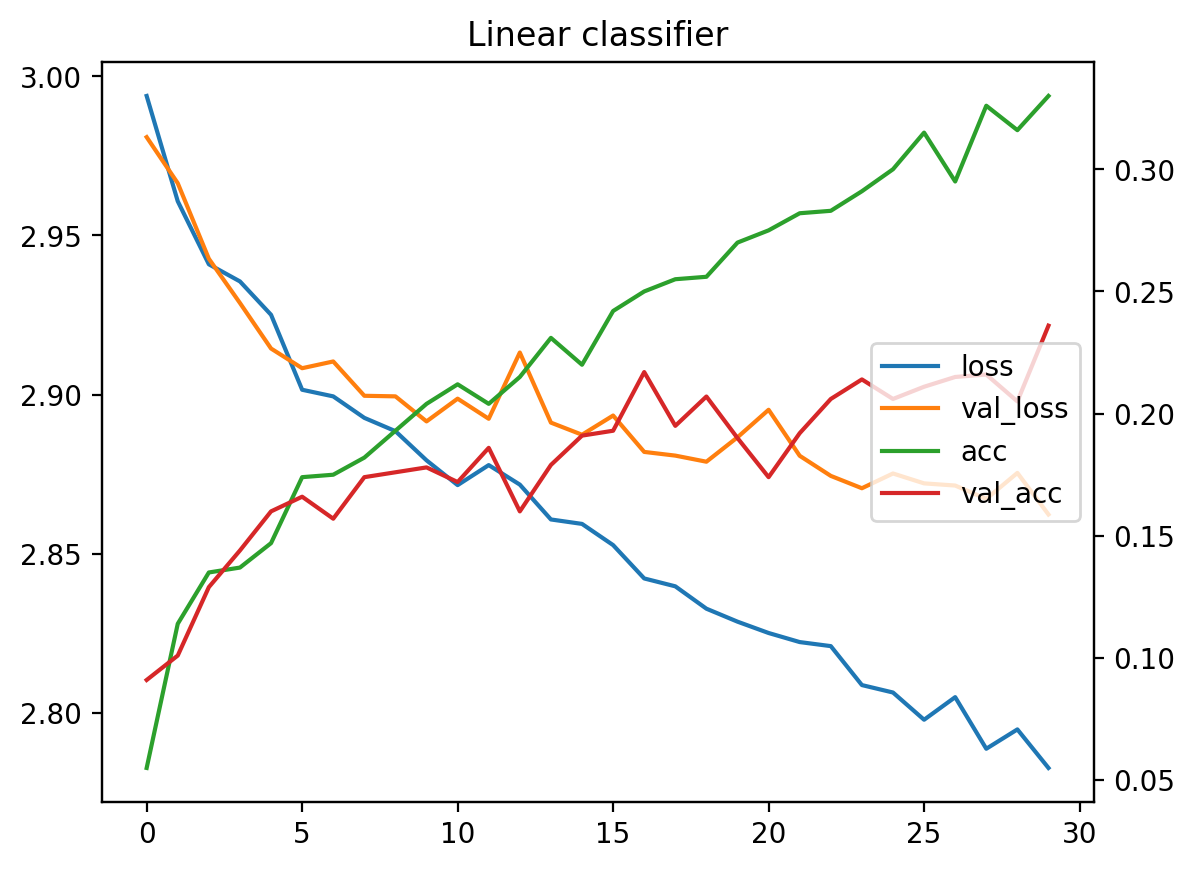

In [18]:
fig = plt.figure(3)
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(log.loss, color='tab:blue')
ax1.plot(log.val_loss, color='tab:orange')
ax2 = ax1.twinx()
ax2.plot(log.acc, color='tab:green')
ax2.plot(log.val_acc, color='tab:red')
fig.legend(
    ['loss', 'val_loss', 'acc', 'val_acc'],
    loc='center right',
    bbox_to_anchor=(1, 0.5),
    bbox_transform=ax1.transAxes,
)
ax2.set_title('Linear classifier')
plt.show()

You can see this model is really learning the task, the accuracy keeps going up and loss on both the training data and even on the validation data keep going down. Despite this being the simplest humble linear classifier - it is somewhat working -- reaching an accuracy of about 26% and it looks like the training started to converge. What would random guessing do on this task?


## **4. Convolutional Neural Networks**

Our classifier in the previous section is not a very good one. In this section, we will define a new classifier that uses instead a convolutional neural network. Here we provide a definition for such neural network. This network is designed to take images as input at a 48x48 resolution.


In [19]:
model = nn.Sequential(
    nn.LazyConv2d(128, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.LazyConv2d(128, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.LazyLinear(num_classes),
)

# Create dummy batch with 24 samples, where each is an image of size 3x48x48.
dummy_batch = torch.zeros(24, 3, 48, 48)
predictions = model(dummy_batch)

# Seems like working to me.
print(dummy_batch.shape, predictions.shape)

torch.Size([24, 3, 48, 48]) torch.Size([24, 20])


## **Questions** [80pts]


### **A.0 Preliminaries** [20pts]

Curve fitting with PyTorch for a simple function. Given the following data points train four parameters so that a polinomial function can be fit to them. Write code in PyTorch using PyTorch Autograd so that you can find coefficients for the following function so that they fit the given data points. Find $w_1$, $w_2$, $w_3$ and $b$ such that:

$$y = f(x) = w_1 x^3 + w_2 x^2 + w_3 x + b$$

Find the values of $w$ so that $L(w_1, w_2, w_3, b) = \sum_i (y_i - f(x_i))^2$ is minimized. Print the values you obtained for these parameters and also plot some predictions for random input $x$ values between 0 and 1 and plot on top of the original points. Some code is provided below.


In [20]:
data = np.array(
    [
        [0.0, 3.09621176],
        [0.05263158, 3.1439874],
        [0.10526316, 3.20488064],
        [0.15789474, 3.25677788],
        [0.21052632, 3.28074662],
        [0.26315789, 3.29389597],
        [0.31578947, 3.31029492],
        [0.36842105, 3.32189618],
        [0.42105263, 3.33234714],
        [0.47368421, 3.33545394],
        [0.52631579, 3.33849267],
        [0.57894737, 3.31554205],
        [0.63157895, 3.31275422],
        [0.68421053, 3.31412129],
        [0.73684211, 3.33618809],
        [0.78947368, 3.30658756],
        [0.84210526, 3.29551117],
        [0.89473684, 3.28314684],
        [0.94736842, 3.28691712],
        [1.0, 3.29905823],
    ]
)

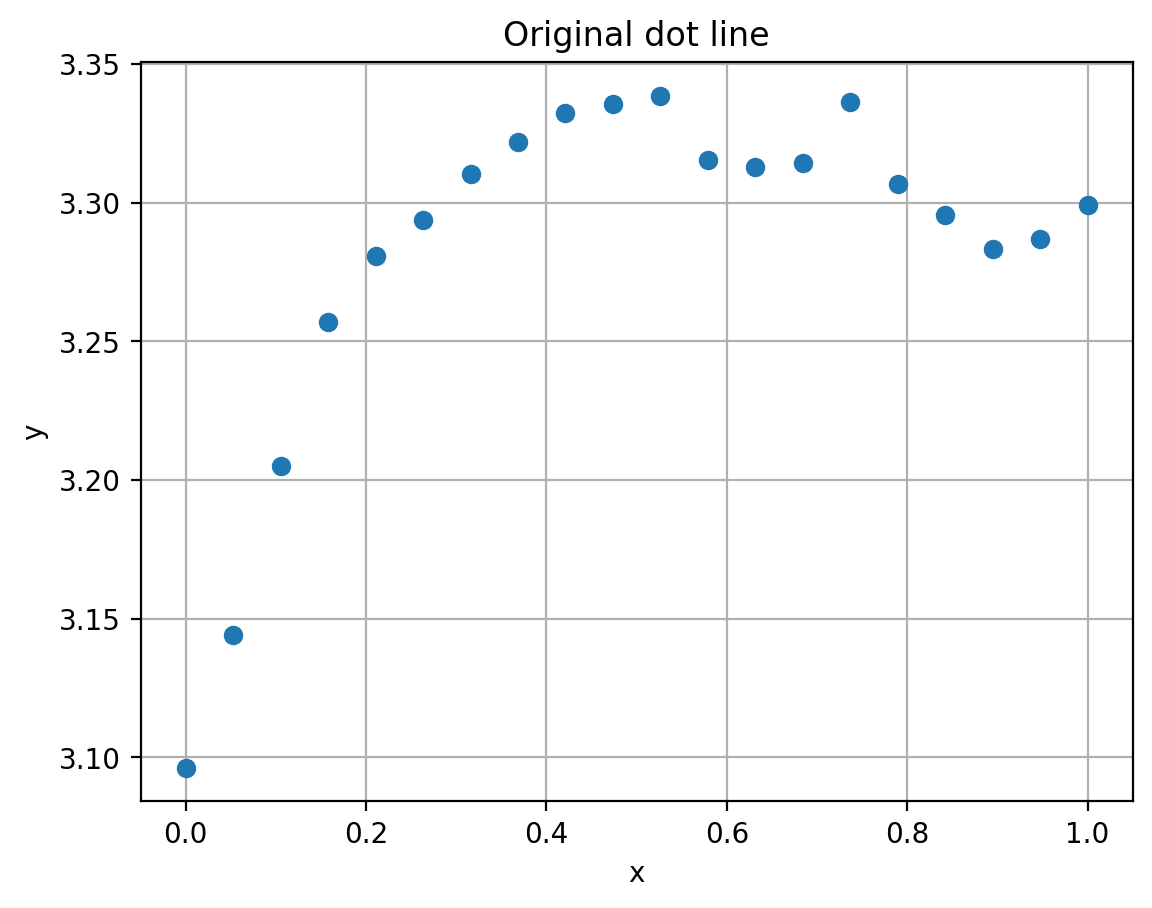

In [21]:
fig = plt.figure(4)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(data[:, 0], data[:, 1], zorder=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(True)
ax.set_title('Original dot line')
plt.show()

We provide here some starting code, please complete the code using your knowledge of PyTorch. Please, add the generated image [here](https://docs.google.com/spreadsheets/d/13d-wZWo_zaGcdbFaEnDSqpEl-J2VANx1srT62wC7RRQ/edit?usp=sharing) (tab: Optimization).


In [22]:
# Train data as tensors.
X = torch.tensor(data[:, 0])
X = torch.stack([X**3, X**2, X, torch.ones_like(X)], dim=1)
y = torch.tensor(data[:, 1])

# Now find w_1, w_2, w_3, and b.
weight = torch.linalg.lstsq(X, y).solution
print(weight)

tensor([ 0.9041, -1.9112,  1.2060,  3.0961], dtype=torch.float64)


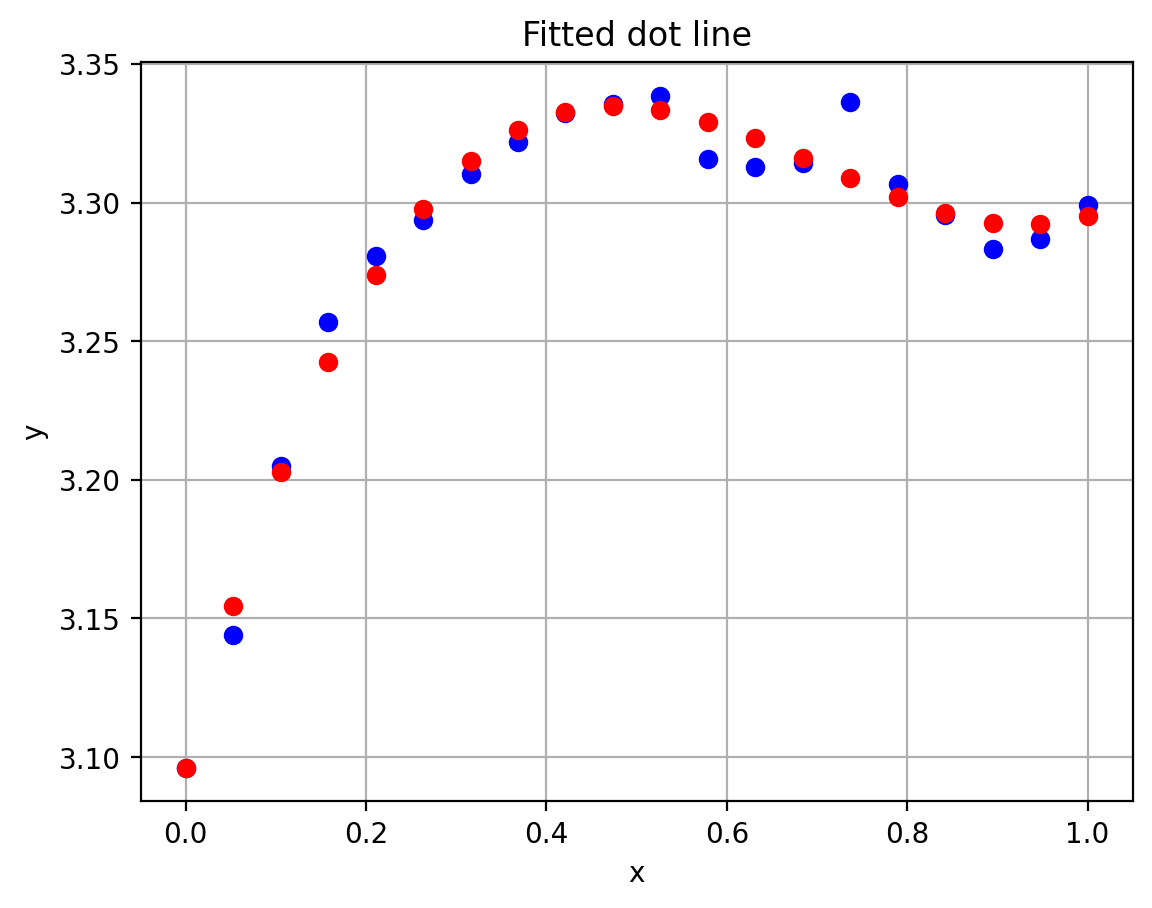

In [23]:
# Plot some sample points using your function with the found parameters.
xx = torch.tensor(data[:, 0])
xx = torch.stack([xx**3, xx**2, xx, torch.ones_like(xx)], dim=1)
yy = torch.matmul(xx, weight)

fig = plt.figure(5)
ax = fig.add_subplot(1, 1, 1)
# Plot the original data in blue.
ax.scatter(data[:, 0], data[:, 1], color='blue', zorder=2)
# Plot new points by sampling from your function f(w1, w2, w3, b).
ax.scatter(data[:, 0], yy.numpy(), color='red', zorder=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(True)
ax.set_title('Fitted dot line')
plt.show()

### **A.1 Train the Convolutional Neural Network from Section 4** [10pts]

Section 4 provides a simple convolutional neural network for you but does not show how to train it. Use the space below to write code to train the neural network. Feel free to re-use code from sections 3 and 4 of this assignment which are provided for you. The most important part is setting up the data appropriately and choosing the right variables such as learning rate, epochs, batch size, optimizer choices, etc. See the sample output below -- it is expected that you achieve about the same validation accuracy to obtain full points on this part.

**Note:** Keep in mind that for you to score points your output needs to be on the notebook -- only providing code doesn't earn any points.


In [24]:
# Reset seed.
np.random.seed(42)
torch.manual_seed(42)

# Prepare the dataset.
train_tf = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomResizedCrop(size=48, scale=(0.7, 1.0)),
        v2.TrivialAugmentWide(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
val_tf = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((48, 48)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_ds = SUN20(
    'deep-learning/datasets',
    split='train',
    transform=train_tf,
    download=True,
)
val_ds = SUN20(
    'deep-learning/datasets',
    split='val',
    transform=val_tf,
    download=True,
)
num_classes = len(train_ds.classes)
print(f'Number of classes: {num_classes}')

# Load train and validation sets.
num_workers = 0 if sys.platform == 'win32' else 2
train_dl = utils.DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=False,
)
val_dl = utils.DataLoader(
    val_ds,
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
)

# Define the model.
model = nn.Sequential(
    nn.LazyConv2d(128, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.LazyConv2d(128, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.LazyLinear(num_classes),
).to(device)
print(f'Using device: {device}')

# torch.nn.CrossEntropyLoss applies the softmax to the predictions by the model.
loss_fn = nn.CrossEntropyLoss()

# Basic AdamW Optimizer.
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

# Define evaluation metrics.
train_metric = metrics.MulticlassAccuracy(num_classes).to(device)
val_metric = metrics.MulticlassAccuracy(num_classes).to(device)

Number of classes: 20
Using device: cuda


In [25]:
log = train(
    model=model,
    train_dl=train_dl,
    val_dl=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    train_metric=train_metric,
    val_metric=val_metric,
    num_epochs=40,
    model_name='model-cnn-demo',
    log_name='log-cnn-demo',
)

Epoch 1/40 - loss: 3.0002 - acc: 0.0730 - val_loss: 2.7534 - val_acc: 0.1380
Model improved. Time taken until now: 2.88 seconds.
Epoch 2/40 - loss: 2.7537 - acc: 0.1460 - val_loss: 2.4999 - val_acc: 0.2120
Model improved. Time taken until now: 5.22 seconds.
Epoch 3/40 - loss: 2.6210 - acc: 0.1980 - val_loss: 2.3461 - val_acc: 0.2450
Model improved. Time taken until now: 7.56 seconds.
Epoch 4/40 - loss: 2.5289 - acc: 0.2150 - val_loss: 2.2968 - val_acc: 0.2360
Model improved. Time taken until now: 9.85 seconds.
Epoch 5/40 - loss: 2.4638 - acc: 0.2560 - val_loss: 2.2898 - val_acc: 0.2650
Model improved. Time taken until now: 12.18 seconds.
Epoch 6/40 - loss: 2.4446 - acc: 0.2590 - val_loss: 2.2452 - val_acc: 0.2840
Model improved. Time taken until now: 14.50 seconds.
Epoch 7/40 - loss: 2.3727 - acc: 0.2610 - val_loss: 2.0957 - val_acc: 0.3180
Model improved. Time taken until now: 16.82 seconds.
Epoch 8/40 - loss: 2.2956 - acc: 0.2800 - val_loss: 2.0557 - val_acc: 0.3360
Model improved. T

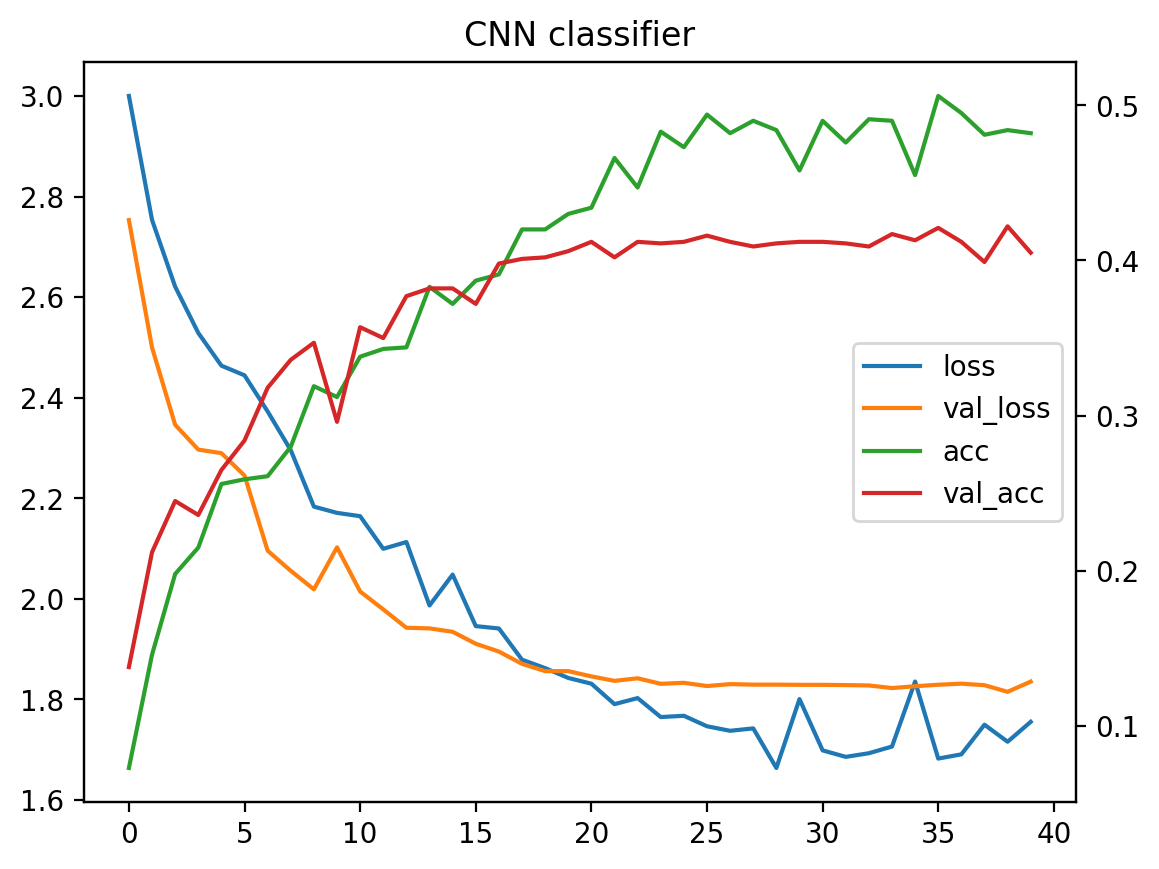

In [26]:
fig = plt.figure(6)
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(log.loss, color='tab:blue')
ax1.plot(log.val_loss, color='tab:orange')
ax2 = ax1.twinx()
ax2.plot(log.acc, color='tab:green')
ax2.plot(log.val_acc, color='tab:red')
fig.legend(
    ['loss', 'val_loss', 'acc', 'val_acc'],
    loc='center right',
    bbox_to_anchor=(1, 0.5),
    bbox_transform=ax1.transAxes,
)
ax2.set_title('CNN classifier')
plt.show()

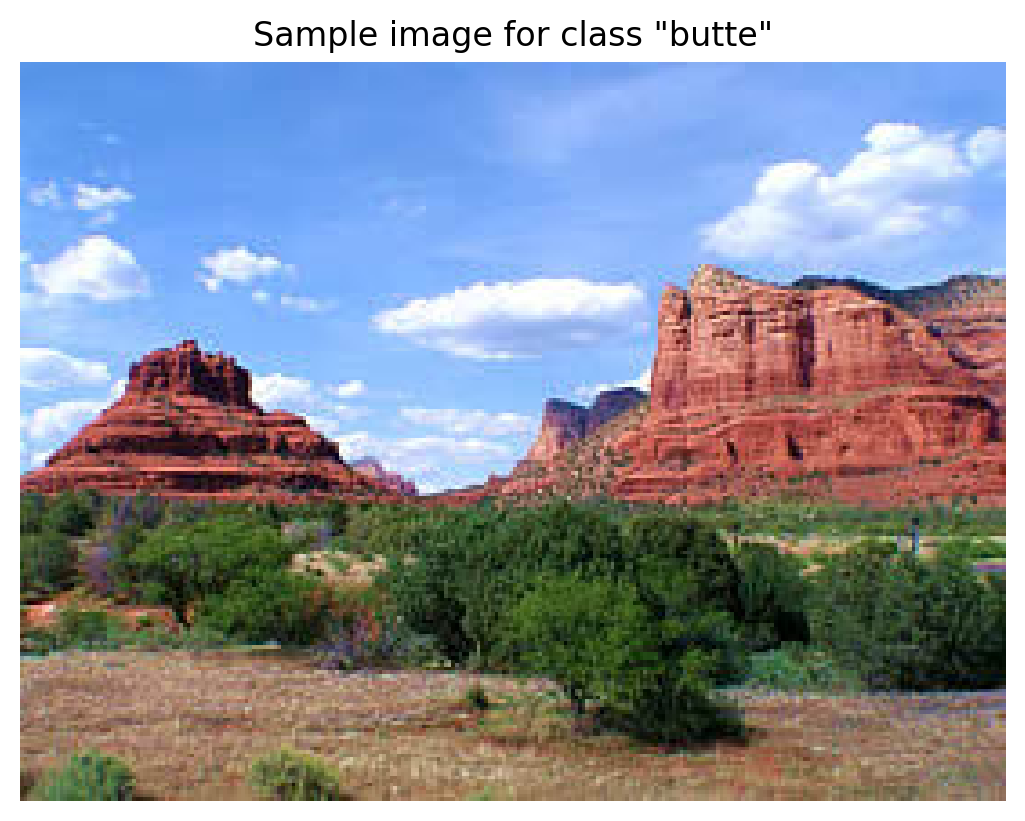

Prob("arch") = 0.01
Prob("bathroom") = 0.00
Prob("butte") = 0.54
Prob("dentists_office") = 0.00
Prob("hot_spring") = 0.00
Prob("jacuzzi/indoor") = 0.00
Prob("lighthouse") = 0.06
Prob("laundromat") = 0.00
Prob("lecture_room") = 0.00
Prob("living_room") = 0.00
Prob("library/indoor") = 0.00
Prob("mansion") = 0.01
Prob("marsh") = 0.35
Prob("mountain") = 0.01
Prob("sauna") = 0.00
Prob("shower") = 0.00
Prob("skyscraper") = 0.00
Prob("tower") = 0.00
Prob("tree_house") = 0.00
Prob("volcano") = 0.00


In [27]:
# Including an example prediction just for your reference to see the model is really working.
model = nn.Sequential(
    nn.LazyConv2d(128, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.LazyConv2d(128, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.LazyLinear(num_classes),
)
model.load_state_dict(torch.load('model-cnn-demo.ckpt'))
model.to(device)

model.eval()
input_image_idx = 113
X, y = val_ds[input_image_idx]

# Process input and add a dummy batch dimension.
X = torch.unsqueeze(X, dim=0).to(device)
y_pred = model(X)
y_pred = torch.softmax(y_pred, dim=1)

X = val_ds.get_original_image(input_image_idx)

fig = plt.figure(7)
ax = fig.add_subplot(1, 1, 1)
ax.imshow(X)
ax.axis('off')
ax.set_title('Sample image for class "butte"')
plt.show()

# Show predictions from this model.
for i in range(0, num_classes):
    score = y_pred[0, i].item()
    category = val_ds.classes[i]
    print(f'Prob("{category}") = {score:.2f}')

### **A.2 Show Results from the Previously Trained Model** [10pts]

Show results for the model trained in the previous section (sec A.1) by displaying the top 20 images from the validation set that the model predicts as `butte`. Show the predicted scores for each somehow and put a green box around the images that are indeed a `butte` and a red box around the images whose true label is not `butte` as shown below. I used the Pillow's library ImageDraw class to draw a rectangle and draw some text on the images.


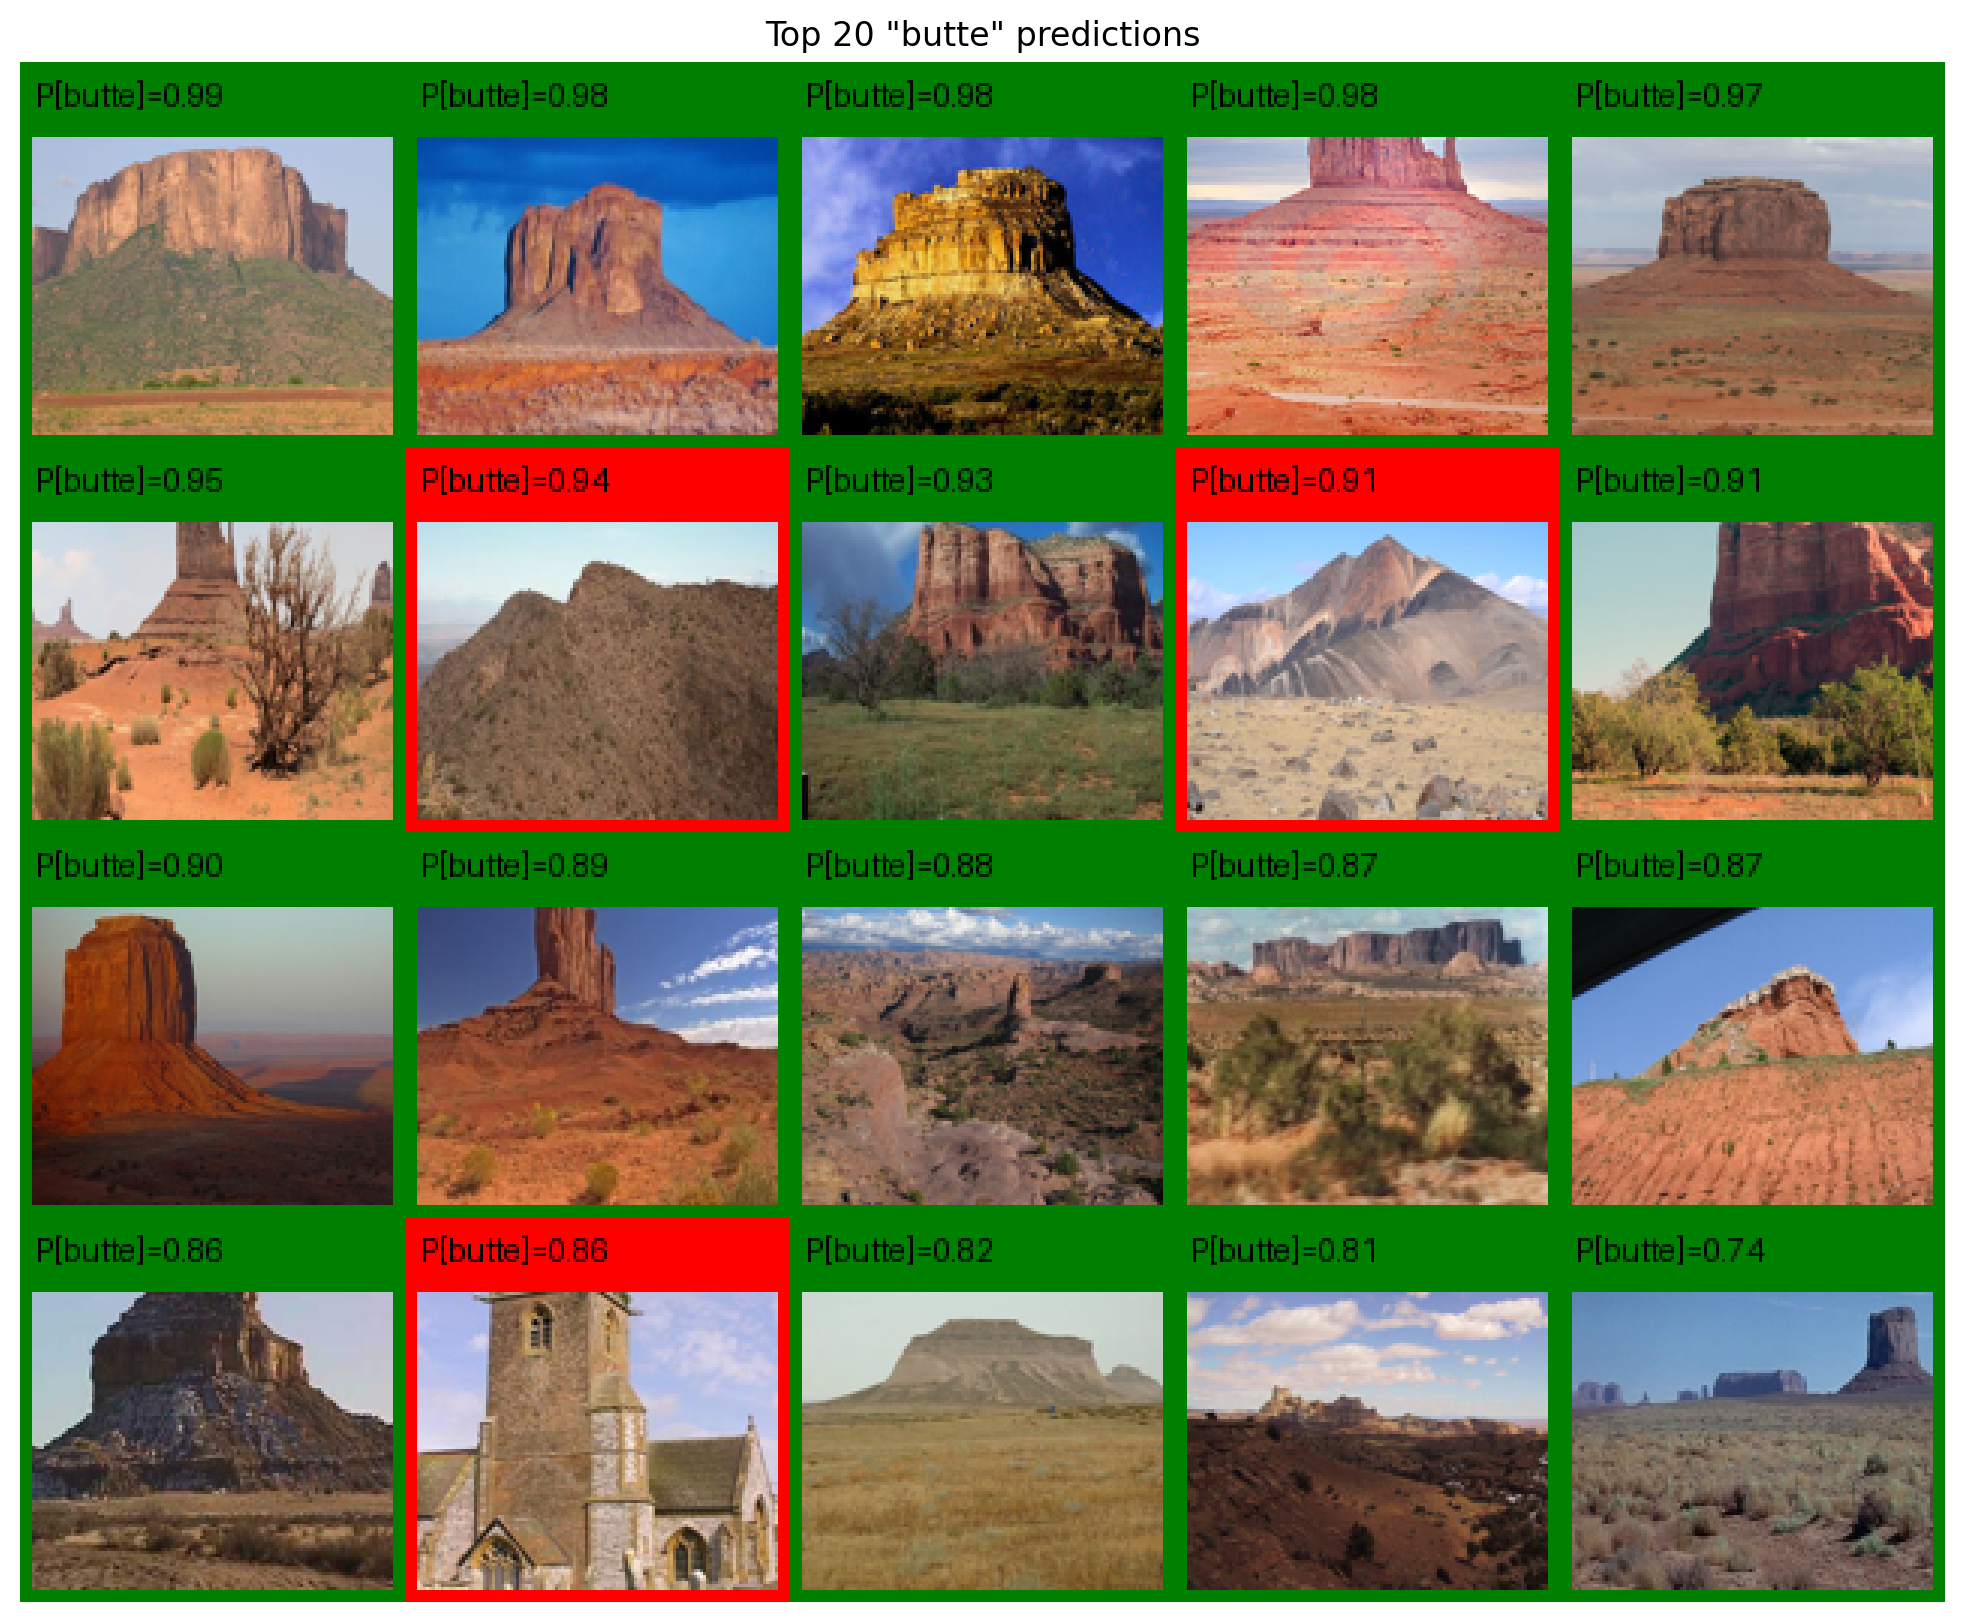

In [28]:
model.eval()
results = []
image_idx = 0
butte_class_idx = train_ds.class_to_idx['butte']

with torch.no_grad():
    for images, labels in val_dl:
        images, labels = images.to(device), labels.to(device)
        probs = torch.softmax(model(images), dim=1)

        for image, label, prob in zip(images, labels, probs):
            results.append(
                (
                    val_ds.get_original_image(image_idx),
                    label.item(),
                    prob[butte_class_idx].item(),
                    prob.argmax().item() == butte_class_idx,
                )
            )
            image_idx += 1

top20 = sorted(
    (r for r in results if r[3]),
    key=lambda x: x[2],
    reverse=True,
)[:20]


def draw_box(image: Image.Image, p: float, is_true: bool) -> np.ndarray:
    image = image.resize((128, 128))

    draw = ImageDraw.Draw(image)
    w, h = image.size
    color = 'green' if is_true else 'red'

    draw.rectangle([0, 0, w - 1, h - 1], outline=color, width=4)
    draw.rectangle([0, 0, w, 24], fill=color)
    draw.text((5, 5), f'P[butte]={p:.2f}', fill='black')

    return np.array(image)


image = [draw_box(image, p, y == butte_class_idx) for image, y, p, _ in top20]
grid_image = make_grid_np(image, nrow=5)

fig = plt.figure(8, figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid_image)
ax.axis('off')
ax.set_title('Top 20 "butte" predictions')
plt.show()

### **A.3 Define and Train a Better Convolutional Neural Network** [20pts]

In section 4 and A.1 we defined and trained a ConvNet, however we were only able to reach somewhat above 30% in accuracy. We should be able to do better with a ConvNet if we add perhaps more layers, or batch normalization layers, or add some forms of regularization such as dropout layers, data augmentation, or choose optimization parameters more carefully -- or consider processing the images at a higher resolution than 48x48. Design and train a CNN that obtains at least 52% accuracy. This number is slightly lower than the average accuracy that students obtained in a previous version of this class. The very best submissions obtained 60% accuracy or more, one obtained 58% with a training time under 5 minutes. My solution below was not in the top 10. To get full points in this question the network has to perform on par with what is shown here. Additionally, you have to enter the following information: number of parameters of your network, training time of your network, and the maximum validation accuracy achieved [here](https://docs.google.com/spreadsheets/d/13d-wZWo_zaGcdbFaEnDSqpEl-J2VANx1srT62wC7RRQ/edit?usp=sharing). (Tab: SUN20-from-scratch-CNN)


In [29]:
# Reset seed.
np.random.seed(42)
torch.manual_seed(42)

# Prepare the dataset.
train_tf = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomResizedCrop(size=224, scale=(0.7, 1.0)),
        v2.TrivialAugmentWide(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
val_tf = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_ds = SUN20(
    'deep-learning/datasets',
    split='train',
    transform=train_tf,
    download=True,
)
val_ds = SUN20(
    'deep-learning/datasets',
    split='val',
    transform=val_tf,
    download=True,
)
num_classes = len(train_ds.classes)
print(f'Number of classes: {num_classes}')

# Load train and validation sets.
num_workers = 0 if sys.platform == 'win32' else 2
train_dl = utils.DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=False,
)
val_dl = utils.DataLoader(
    val_ds,
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
)

# Define the model.
model = models.resnet18(num_classes=num_classes).to(device)
print(f'Using device: {device}')

# torch.nn.SoftTargetCrossEntropy applies the softmax to the predictions by the model.
loss_fn = SoftTargetCrossEntropy()
mixup_fn = v2.MixUp(alpha=0.2, num_classes=num_classes)

# Basic AdamW Optimizer.
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Define evaluation metrics.
train_metric = metrics.MulticlassAccuracy(num_classes).to(device)
val_metric = metrics.MulticlassAccuracy(num_classes).to(device)

Number of classes: 20
Using device: cuda


In [30]:
log = train(
    model=model,
    train_dl=train_dl,
    val_dl=val_dl,
    loss_fn=loss_fn,
    mixup_fn=mixup_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    train_metric=train_metric,
    val_metric=val_metric,
    num_epochs=60,
    model_name='model-resnet18',
    log_name='log-resnet18',
    device=device,
)

Epoch 1/60 - loss: 2.9999 - acc: 0.1160 - val_loss: 4.0061 - val_acc: 0.1480
Model improved. Time taken until now: 3.94 seconds.
Epoch 2/60 - loss: 2.6623 - acc: 0.1880 - val_loss: 3.7072 - val_acc: 0.1620
Model improved. Time taken until now: 7.73 seconds.
Epoch 3/60 - loss: 2.5966 - acc: 0.2100 - val_loss: 2.5312 - val_acc: 0.2390
Model improved. Time taken until now: 11.58 seconds.
Epoch 4/60 - loss: 2.5622 - acc: 0.2560 - val_loss: 2.2377 - val_acc: 0.2820
Model improved. Time taken until now: 15.52 seconds.
Epoch 5/60 - loss: 2.4391 - acc: 0.2530 - val_loss: 2.1538 - val_acc: 0.2940
Model improved. Time taken until now: 19.39 seconds.
Epoch 6/60 - loss: 2.3885 - acc: 0.2920 - val_loss: 2.2550 - val_acc: 0.2930
Epoch 7/60 - loss: 2.1914 - acc: 0.3280 - val_loss: 1.9806 - val_acc: 0.3500
Model improved. Time taken until now: 27.21 seconds.
Epoch 8/60 - loss: 2.3537 - acc: 0.3180 - val_loss: 1.9038 - val_acc: 0.3490
Model improved. Time taken until now: 31.13 seconds.
Epoch 9/60 - lo

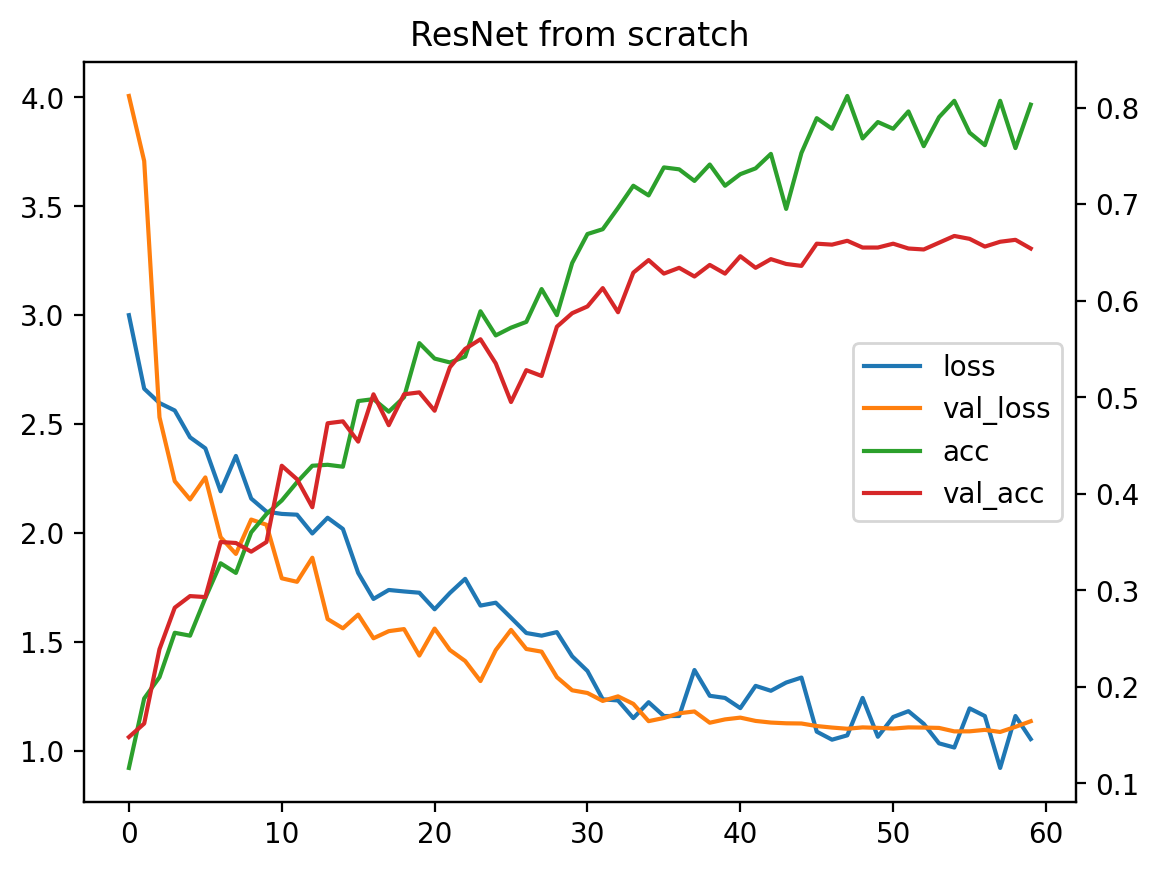

In [31]:
fig = plt.figure(9)
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(log.loss, color='tab:blue')
ax1.plot(log.val_loss, color='tab:orange')
ax2 = ax1.twinx()
ax2.plot(log.acc, color='tab:green')
ax2.plot(log.val_acc, color='tab:red')
fig.legend(
    ['loss', 'val_loss', 'acc', 'val_acc'],
    loc='center right',
    bbox_to_anchor=(1, 0.5),
    bbox_transform=ax1.transAxes,
)
ax2.set_title('ResNet from scratch')
plt.show()

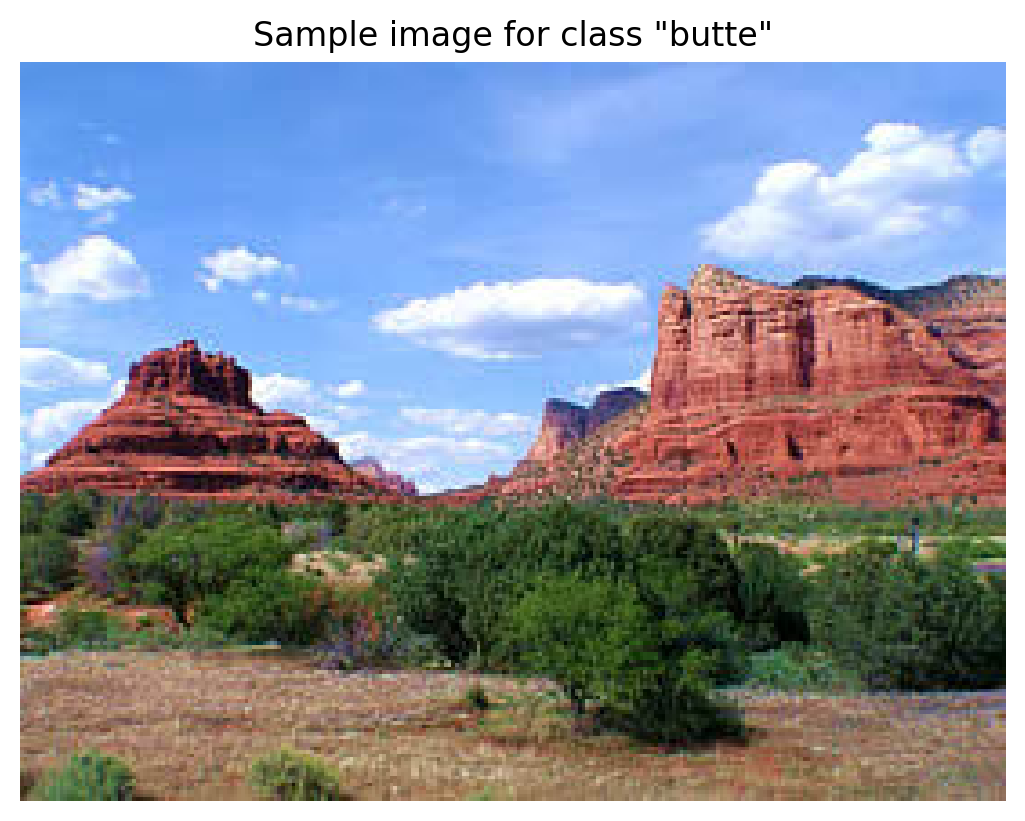

Prob("arch") = 0.01
Prob("bathroom") = 0.00
Prob("butte") = 0.68
Prob("dentists_office") = 0.00
Prob("hot_spring") = 0.00
Prob("jacuzzi/indoor") = 0.00
Prob("lighthouse") = 0.13
Prob("laundromat") = 0.00
Prob("lecture_room") = 0.00
Prob("living_room") = 0.00
Prob("library/indoor") = 0.00
Prob("mansion") = 0.01
Prob("marsh") = 0.07
Prob("mountain") = 0.04
Prob("sauna") = 0.00
Prob("shower") = 0.00
Prob("skyscraper") = 0.01
Prob("tower") = 0.01
Prob("tree_house") = 0.00
Prob("volcano") = 0.03


In [32]:
# Including an example prediction just for your reference to see the model is really working.
model = models.resnet18(num_classes=num_classes)
model.load_state_dict(torch.load('model-resnet18.ckpt'))
model.to(device)

model.eval()
input_image_idx = 113
X, y = val_ds[input_image_idx]

# Process input and add a dummy batch dimension.
X = torch.unsqueeze(X, dim=0).to(device)
y_pred = model(X)
y_pred = torch.softmax(y_pred, dim=1)

X = val_ds.get_original_image(input_image_idx)

fig = plt.figure(10)
ax = fig.add_subplot(1, 1, 1)
ax.imshow(X)
ax.axis('off')
ax.set_title('Sample image for class "butte"')
plt.show()

# Show predictions from this model.
for i in range(0, num_classes):
    score = y_pred[0, i].item()
    category = val_ds.classes[i]
    print(f'Prob("{category}") = {score:.2f}')

In [33]:
model.eval()
results = []
image_idx = 0
butte_class_idx = train_ds.class_to_idx['butte']

with torch.no_grad():
    for images, labels in val_dl:
        images, labels = images.to(device), labels.to(device)
        probs = torch.softmax(model(images), dim=1)

        for image, label, prob in zip(images, labels, probs):
            results.append(
                (
                    val_ds.get_original_image(image_idx),
                    label.item(),
                    prob[butte_class_idx].item(),
                    prob.argmax().item() == butte_class_idx,
                )
            )
            image_idx += 1

top20 = sorted(
    (r for r in results if r[3]),
    key=lambda x: x[2],
    reverse=True,
)[:20]

image = [np.array(image.resize((128, 128))) for image, *_ in top20]
grid_image = make_grid_np(image, nrow=10)

fig = plt.figure(11, figsize=(18, 6))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid_image)
ax.axis('off')
ax.set_title('Images with largest predicted scores for class "butte"')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### **A.4 Finetuning an Existing Neural Network from PyTorch's Model Library** [20pts]

PyTorch contains a rich library of pretrained models -- models that have already been trained over a really large scale dataset, often with millions of images and thousands of categories. Re-use one of these models with its pretrained weights and "finetune" it to perform well on the SUN20 dataset by replacing the last layer with a layer that predicts 20 outputs and run a couple of rounds of finetuning until you achieve a classifier that performs at about 90% accuracy -- ideally more. I used EfficientNet V2 Medium Size to obtain the performance below at 91.8% in just 7 epochs. Please enter the information for your implementation [here](https://docs.google.com/spreadsheets/d/13d-wZWo_zaGcdbFaEnDSqpEl-J2VANx1srT62wC7RRQ/edit?usp=sharing) (Tab: SUN20-pretrained-CNN)

Some helpful links are:

- [Deep Learning With Images](https://PyTorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
- [Fine-Tunning](https://PyTorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [PyTorch Models](https://PyTorch.org/vision/stable/models.html)
- [Data Augmentation](https://towardsdatascience.com/image-augmentation-using-python-numpy-opencv-and-skimage-ef027e9898da)
- [DataSet DataLoader](https://PyTorch.org/tutorials/beginner/basics/data_tutorial.html)
- [PyTorch Layers](https://PyTorch.org/docs/stable/nn.html)


In [34]:
# Reset seed.
np.random.seed(42)
torch.manual_seed(42)

# Prepare the dataset.
train_tf = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomResizedCrop(size=224, scale=(0.7, 1.0)),
        v2.TrivialAugmentWide(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
val_tf = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_ds = SUN20(
    'deep-learning/datasets',
    split='train',
    transform=train_tf,
    download=True,
)
val_ds = SUN20(
    'deep-learning/datasets',
    split='val',
    transform=val_tf,
    download=True,
)
num_classes = len(train_ds.classes)
print(f'Number of classes: {num_classes}')

# Load train and validation sets.
num_workers = 0 if sys.platform == 'win32' else 2
train_dl = utils.DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=False,
)
val_dl = utils.DataLoader(
    val_ds,
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
)

# Define the model.
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
model.to(device)
print(f'Using device: {device}')

# torch.nn.CrossEntropyLoss applies the softmax to the predictions by the model.
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

# Basic SGD Optimizer.
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

# Define evaluation metrics.
train_metric = metrics.MulticlassAccuracy(num_classes).to(device)
val_metric = metrics.MulticlassAccuracy(num_classes).to(device)

Number of classes: 20
Using device: cuda


In [35]:
log = train(
    model=model,
    train_dl=train_dl,
    val_dl=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_metric=train_metric,
    val_metric=val_metric,
    num_epochs=20,
    model_name='model-convnext-finetune',
    log_name='log-convnext-finetune',
    device=device,
)

Epoch 1/20 - loss: 2.4186 - acc: 0.3720 - val_loss: 1.1107 - val_acc: 0.8210
Model improved. Time taken until now: 15.04 seconds.
Epoch 2/20 - loss: 1.3393 - acc: 0.7540 - val_loss: 0.6512 - val_acc: 0.8420
Model improved. Time taken until now: 20.84 seconds.
Epoch 3/20 - loss: 1.1813 - acc: 0.7860 - val_loss: 0.5294 - val_acc: 0.8440
Model improved. Time taken until now: 26.65 seconds.
Epoch 4/20 - loss: 1.0857 - acc: 0.8270 - val_loss: 0.5784 - val_acc: 0.8350
Epoch 5/20 - loss: 1.0390 - acc: 0.8510 - val_loss: 0.3987 - val_acc: 0.8860
Model improved. Time taken until now: 38.12 seconds.
Epoch 6/20 - loss: 0.9154 - acc: 0.9020 - val_loss: 0.4209 - val_acc: 0.8950
Epoch 7/20 - loss: 0.8731 - acc: 0.9230 - val_loss: 0.3918 - val_acc: 0.9090
Model improved. Time taken until now: 49.57 seconds.
Epoch 8/20 - loss: 0.8583 - acc: 0.9260 - val_loss: 0.3595 - val_acc: 0.9150
Model improved. Time taken until now: 55.36 seconds.
Epoch 9/20 - loss: 0.8421 - acc: 0.9370 - val_loss: 0.4255 - val_a

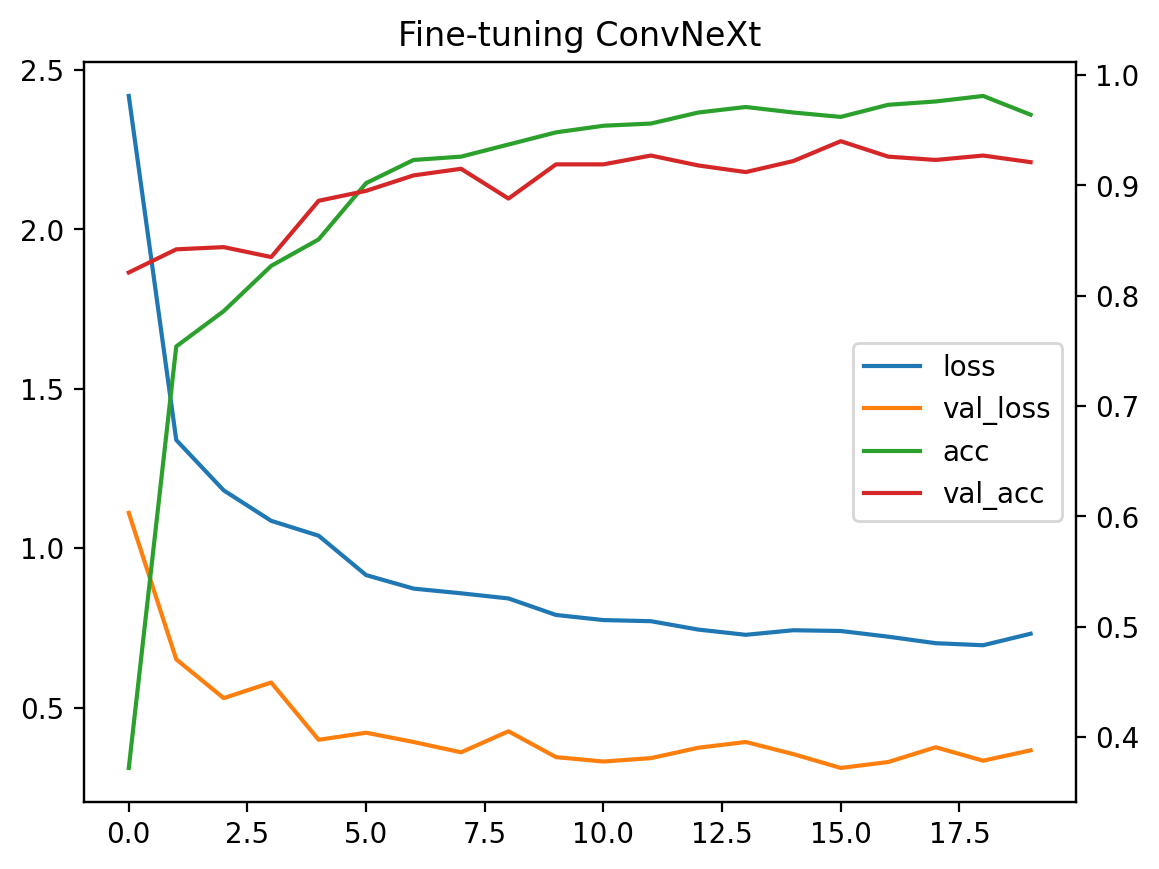

In [36]:
fig = plt.figure(12)
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(log.loss, color='tab:blue')
ax1.plot(log.val_loss, color='tab:orange')
ax2 = ax1.twinx()
ax2.plot(log.acc, color='tab:green')
ax2.plot(log.val_acc, color='tab:red')
fig.legend(
    ['loss', 'val_loss', 'acc', 'val_acc'],
    loc='center right',
    bbox_to_anchor=(1, 0.5),
    bbox_transform=ax1.transAxes,
)
ax2.set_title('Fine-tuning ConvNeXt')
plt.show()

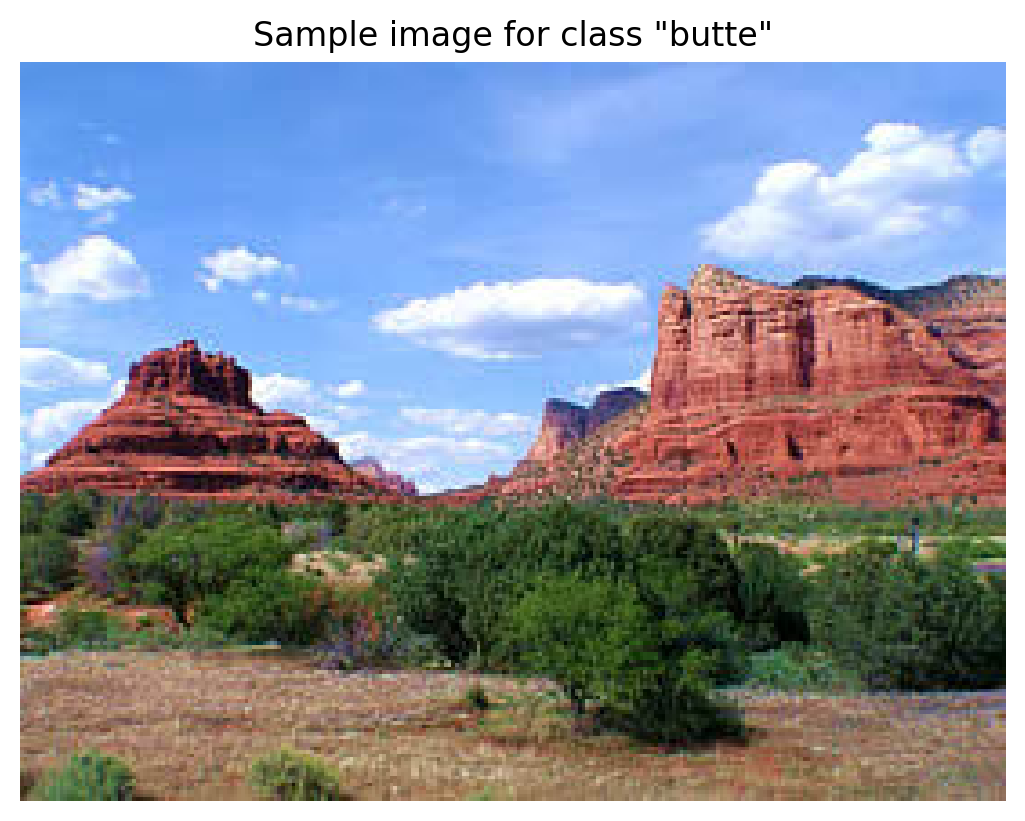

Prob("arch") = 0.00
Prob("bathroom") = 0.00
Prob("butte") = 0.98
Prob("dentists_office") = 0.00
Prob("hot_spring") = 0.00
Prob("jacuzzi/indoor") = 0.00
Prob("lighthouse") = 0.00
Prob("laundromat") = 0.00
Prob("lecture_room") = 0.00
Prob("living_room") = 0.00
Prob("library/indoor") = 0.00
Prob("mansion") = 0.00
Prob("marsh") = 0.00
Prob("mountain") = 0.00
Prob("sauna") = 0.00
Prob("shower") = 0.00
Prob("skyscraper") = 0.00
Prob("tower") = 0.00
Prob("tree_house") = 0.00
Prob("volcano") = 0.00


In [37]:
# Including an example prediction just for your reference to see the model is really working.
input_image_idx = 113
X, y = val_ds[input_image_idx]

# Process input and add a dummy batch dimension.
X = torch.unsqueeze(X, dim=0).to(device)
y_pred = model(X)
y_pred = torch.softmax(y_pred, dim=1)

X = val_ds.get_original_image(input_image_idx)

fig = plt.figure(13)
ax = fig.add_subplot(1, 1, 1)
ax.imshow(X)
ax.axis('off')
ax.set_title('Sample image for class "butte"')
plt.show()

# Show predictions from this model.
for i in range(0, num_classes):
    score = y_pred[0, i].item()
    category = val_ds.classes[i]
    print(f'Prob("{category}") = {score:.2f}')

## **Acknowledgements**

This homework came from [Deep Learning for Vision and Language](https://www.cs.rice.edu/~vo9/deep-vislang/) from Prof. Vicente Ordoñez (Rice University).
